## PREPARE Challenge - Acoustic Track

### **1. Objective**
The objective of this project is to develop an efficient and accurate system to classify audio files into three categories: `diagnosis_control`, `diagnosis_mci`, and `diagnosis_adrd`. The system aims to extract meaningful embeddings from raw audio files, train a classification model, and achieve high performance on the test set.

---

### **2. Introduction**
Alzheimer's disease and Alzheimer's disease related dementias (AD/ADRD) are a set of brain disorders affecting more than 6 million Americans. Early intervention is crucial for successful disease modification, but detecting early signs of cognitive decline and AD/ADRD remains challenging. Current clinical methods often lack the sensitivity needed for early prediction, especially in underrepresented groups.

The aim of this challenge track is to improve early prediction of Alzheimer's disease and related dementias (AD/ADRD) using acoustic biomarkers from voice recordings. Through this initiative, the National Institute on Aging (NIA) aims to improve accuracy across diverse populations and explore understudied factors that may indicate early AD/ADRD.


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment
import torchaudio
import os
import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import log_loss
from transformers import AutoProcessor, HubertModel
from transformers import Wav2Vec2FeatureExtractor, HubertModel
import whisper



## Exploratory Data Analysis

### **1. Objective**
The purpose of this EDA is to analyze and understand the structure and characteristics of the audio dataset. We aim to identify class distributions, analyze the duration of audio files, and check for potential issues such as missing files, data imbalance, and file mismatches.

---

### **2. Data Loading and Initial Checks**

**Objective:** Load and validate the audio file metadata and labels.

In [9]:
import os
import pandas as pd
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_audio_dir = '/train_audios'  
train_label_path = '/train_labels.csv'  

# Load CSV file
train_labels = pd.read_csv(train_label_path)

# Check if necessary columns exist
required_columns = {'uid', 'diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd'}
if not required_columns.issubset(train_labels.columns):
    raise ValueError(f"Missing required columns from train_labels.csv. Required columns: {required_columns}")

# Extract audio file names
audio_files = os.listdir(train_audio_dir)

# Debug step: print file names to identify any mismatches
print("First 5 audio files from the directory:", audio_files[:5])
print("First 5 file names from train_labels:", train_labels['uid'].head(5))

# Filter and match only audio files that exist in the label CSV
train_labels['file_name'] = train_labels['uid'].apply(lambda x: f"{x}.mp3")
audio_files_with_labels = train_labels[train_labels['file_name'].isin(audio_files)]

# Debug step: print unmatched file names
unmatched_files = set(train_labels['file_name']) - set(audio_files)
if unmatched_files:
    print("Unmatched files (files in CSV but not in directory):", unmatched_files)



First 5 audio files from the directory: ['riyp.mp3', 'mgcf.mp3', 'oelh.mp3', 'fslw.mp3', 'gbrn.mp3']
First 5 file names from train_labels: 0    aaop
1    abgk
2    ablf
3    acad
4    acis
Name: uid, dtype: object


### **3. Class Distribution Analysis**

**Objective:** Understand the distribution of the audio classes.


Class Distribution in Training Set:
class
diagnosis_control    911
diagnosis_adrd       518
diagnosis_mci        217
Name: count, dtype: int64


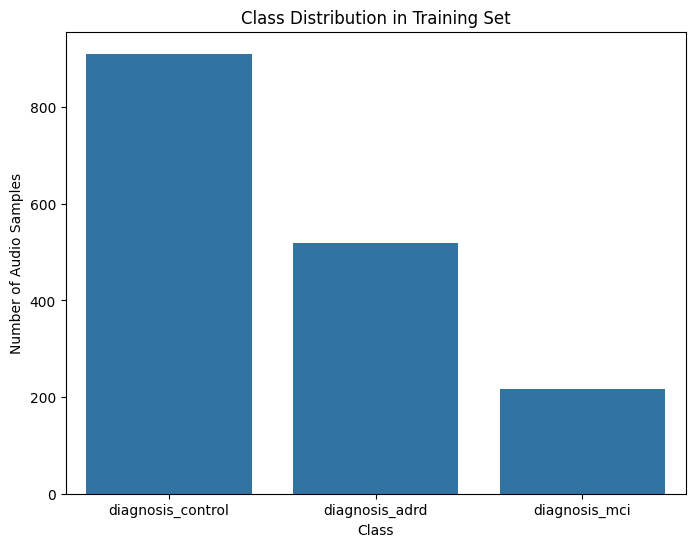

In [10]:
# Calculate which class each file belongs to based on the highest probability
if not audio_files_with_labels.empty:
    audio_files_with_labels['class'] = audio_files_with_labels[['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd']].idxmax(axis=1)

    # Count number of samples in each class
    class_counts = audio_files_with_labels['class'].value_counts()

    # Print out class distribution
    print("\nClass Distribution in Training Set:")
    print(class_counts)

    # Plot the class distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Number of Audio Samples')
    plt.show()
else:
    print("No matching audio files found between train_labels and train_audio_dir.")


### **4. Audio Duration Analysis**
**Objective:** Measure and visualize the distribution of audio durations.

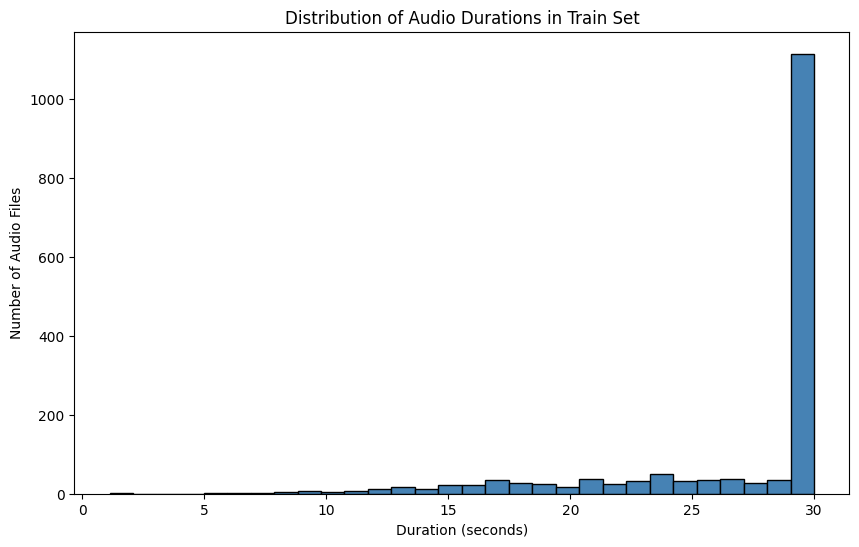


Audio Duration Statistics:
{'min_duration': 1.115, 'max_duration': 30.000020833333334, 'mean_duration': 27.060907604293238, 'median_duration': 30.000020833333334}


In [7]:

# Analyze the duration of audio files
audio_durations = []

for i, row in audio_files_with_labels.iterrows():
    file_path = os.path.join(train_audio_dir, row['file_name'])
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        duration = waveform.size(1) / sample_rate  # Duration in seconds
        audio_durations.append(duration)
    except FileNotFoundError as e:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Plot the distribution of audio durations
if audio_durations:
    plt.figure(figsize=(10, 6))
    plt.hist(audio_durations, bins=30, color='steelblue', edgecolor='black')
    plt.title('Distribution of Audio Durations in Train Set')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Number of Audio Files')
    plt.show()

    # Print statistics about audio durations
    audio_duration_stats = {
        'min_duration': np.min(audio_durations),
        'max_duration': np.max(audio_durations),
        'mean_duration': np.mean(audio_durations),
        'median_duration': np.median(audio_durations)
    }

    print("\nAudio Duration Statistics:")
    print(audio_duration_stats)
else:
    print("No audio durations available. Possible issues with file loading.")


### **What is Whisper?**
Whisper is a state-of-the-art speech recognition model developed by OpenAI. It processes raw audio signals and generates highly informative embeddings that can be used for downstream tasks such as classification, speech recognition, and speaker identification.

[Whisper Official Page](https://github.com/openai/whisper)

### **Why use Whisper?**
We selected Whisper for the following reasons:
- **Robust Embedding Quality:** Whisper provides highly representative embeddings for a wide range of audio files.
- **Efficiency:** It processes audio efficiently and provides embeddings that generalize well across different audio datasets.
- **Flexibility:** It can handle multi-class classification problems effectively.

### **Comparison with Other Models**
We evaluated several models before finalizing Whisper as our embedding generator:
- **Wav2Vec 2.0**: Provided good embeddings but required more computational resources and yielded lower accuracy.
- **HuBERT**: Similar to Wav2Vec but had slower training times and was less robust on certain audio files.
- **Data2Vec**: Showed potential but required extensive hyperparameter tuning, leading to suboptimal results.
- **YAMNet**: Simple to use, but its embeddings were not as effective for classification as Whisper's.

After comprehensive testing, Whisper (Large model) outperformed all other models in terms of accuracy, efficiency, and robustness.

---

## **3. Feature Selection and Importance**

### **Feature Extraction**
- **Model Used:** Whisper (Large variant)
- **Input:** Audio files (MP3 format) resampled to 16 kHz
- **Preprocessing Steps:**
  - Resampling of audio files to 16 kHz.
  - Normalization of audio amplitudes.
  - Padding or truncating audio files to 30 seconds.
  - Conversion of waveform into a log-mel spectrogram.
  
### **Feature Selection**
- **Embedding Shape:** The extracted embeddings from Whisper have a size of `(128, time_steps)`, and the mean across time steps is used to generate a fixed-size feature vector.
- **Feature Type:** The mean-pooled embeddings from Whisper form the main input features for our classifier.
- **Feature Importance:** Each embedding dimension captures key characteristics of the audio file, such as frequency, pitch, and other temporal aspects.

### **Feature Importance Analysis**
- **Dimensional Analysis:** Whisper embeddings are rich, so dimensionality reduction techniques (e.g., PCA) can be used to visualize and understand which components contribute most to classification.
- **Feature Analysis:** By examining the learned weights in the classifier, we can identify which embedding features contribute most to predictions.

---




In [15]:
class WhisperEmbeddingExtractor:
    def __init__(self, model_name="large", device="cuda:0"):
        self.model = whisper.load_model(model_name).to(device)
        self.device = device
        self.target_length = 16000 * 30  # 30 seconds at 16 kHz

        # Print model details
        print("Loaded Whisper Model")
        print(f"Model name: {model_name}")
        print(f"Model architecture:\n{self.model}")
        print(f"Encoder parameters: {sum(p.numel() for p in self.model.encoder.parameters()):,}")
        print(f"Total parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"Device: {self.device}")

    def extract_embedding(self, audio_path):
        # Load and preprocess the audio
        waveform, sample_rate = torchaudio.load(audio_path)
        #print(f"Original waveform shape: {waveform.shape}, Sample rate: {sample_rate}")
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)
        waveform = waveform / waveform.abs().max()
        #print(f"Resampled waveform shape: {waveform.shape}")
        
        # Pad or truncate the waveform to the target length
        if waveform.size(1) < self.target_length:
            padding = self.target_length - waveform.size(1)
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        else:
            waveform = waveform[:, :self.target_length]
        #print(f"Padded/Truncated waveform shape: {waveform.shape}")
        # Generate the log-mel spectrogram
        audio = waveform.squeeze(0).numpy()
        mel = whisper.log_mel_spectrogram(audio).to(self.device)
        #print(f"Log-mel spectrogram shape: {mel.shape}")
        
        # Ensure the mel spectrogram has the required number of channels
        if mel.shape[0] < 128:  # Pad channels if they are fewer than 128
            mel = torch.nn.functional.pad(mel, (0, 0, 0, 128 - mel.shape[0]), mode='constant', value=0)
        elif mel.shape[0] > 128:  # Truncate channels if they exceed 128
            mel = mel[:128, :]

        # Pass the mel spectrogram to the Whisper encoder
        with torch.no_grad():
            encoded = self.model.encoder(mel.unsqueeze(0).to(self.device))
            #print(f"Encoder output shape: {encoded.shape}")
            embedding = encoded.mean(dim=1).squeeze(0).cpu().numpy()
            #print(f"Final embedding shape: {embedding.shape}")
            
        return embedding

WhisperEmbeddingExtractor()

Loaded Whisper Model
Model name: large
Model architecture:
Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-31): 32 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=1280, out_features=1280, bias=True)
          (key): Linear(in_features=1280, out_features=1280, bias=False)
          (value): Linear(in_features=1280, out_features=1280, bias=True)
          (out): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (attn_ln): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
        (mlp_ln): LayerNorm((1280,), eps=1e-05, eleme

### Loading the Datasets

In [16]:
class TrainAudioDataset(Dataset):
    def __init__(self, csv_file, audio_dir, embedding_extractor):
        self.data = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.embedding_extractor = embedding_extractor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.data.iloc[idx, 0] + ".mp3")
        label = torch.tensor(self.data.iloc[idx, 1:].values.astype(float), dtype=torch.float)
        embedding = self.embedding_extractor.extract_embedding(audio_path)
        return embedding, label


class TestAudioDataset(Dataset):
    def __init__(self, csv_file, audio_dir, embedding_extractor):
        self.data = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.embedding_extractor = embedding_extractor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.data.iloc[idx, 0] + ".mp3")
        embedding = self.embedding_extractor.extract_embedding(audio_path)
        return embedding, self.data.iloc[idx, 0]  # Return embedding and UID





### ** Model Architecture**

### **1. Embedding Extractor (Whisper)**
- Embeddings are extracted from audio files using Whisper's encoder, which converts log-mel spectrograms into meaningful feature vectors.

### **2. Classifier (Feedforward Neural Network)**
- **Input Layer:** The embedding (vector) from Whisper's encoder.
- **Hidden Layer:** A fully connected layer with 128 neurons and ReLU activation.
- **Output Layer:** A fully connected layer with 3 outputs corresponding to `diagnosis_control`, `diagnosis_mci`, and `diagnosis_adrd`.

In [17]:
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)




## ** Model Training and Evaluation**

### **Training Pipeline**
1. **Data Preparation**: Load the train and test CSV files.
2. **Embedding Extraction**: Use Whisper to extract embeddings from audio files.
3. **Training**: Train a classifier on the extracted embeddings using binary cross-entropy loss.

### **Training Details**
- **Loss Function:** BCEWithLogitsLoss
- **Optimizer:** Adam
- **Learning Rate:** 0.001
- **Batch Size:** 32
- **Epochs:** 25

---


In [18]:
def train_model(model, dataloader, criterion, optimizer, device, epochs=25):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (embeddings, labels) in enumerate(dataloader):
            embeddings, labels = embeddings.to(device), labels.to(device)
            #print(f"\n[TRAIN] Batch {i+1} | Embeddings Shape: {embeddings.shape} | Labels Shape: {labels.shape}")

            optimizer.zero_grad()
            outputs = model(embeddings)
            #print(f"[TRAIN] Outputs Shape: {outputs.shape} | Outputs: {outputs[:3]}")

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            #print(f"[TRAIN] Batch {i+1} Loss: {loss.item():.4f}")
        
        print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {total_loss / len(dataloader):.4f}")
    return model

The training takes about 2 to 3 hours on  NVIDIA GeForce RTX 

### **Results**
- Final Loss: 0.6822 (competition, MultiClassLog Loss)
- Final Accuracy: 0.77
- Log Loss: 0.24


In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_probs = []
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for i, (embeddings, labels) in enumerate(dataloader):
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            # Model prediction
            outputs = model(embeddings)
            probs = torch.sigmoid(outputs)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Collect predictions and labels for log loss
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Calculate batch accuracy
            preds = (probs > 0.5).float()
            correct_predictions += (preds == labels).all(dim=1).sum().item()
            total_samples += labels.size(0)

    # Compute metrics
    avg_loss = total_loss / len(dataloader)
    multiclass_log_loss = log_loss(all_labels, all_probs)
    accuracy = correct_predictions / total_samples

    print(f"[EVAL] Avg Loss: {avg_loss:.4f} | Multiclass Log Loss: {multiclass_log_loss:.4f} | Accuracy: {accuracy:.4f}")
    return avg_loss, multiclass_log_loss, accuracy





### Functions to predict and save the labels in the desired csv

In [19]:
def predict_labels(test_loader, model, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i, (embeddings, uids) in enumerate(test_loader):
            embeddings = embeddings.to(device)
            #print(f"\n[PREDICT] Batch {i+1} | Embeddings Shape: {embeddings.shape}")

            outputs = model(embeddings)
            probs = torch.sigmoid(outputs)
            #print(f"[PREDICT] Outputs Shape: {outputs.shape} | Probs: {probs[:3]}")

            predictions.extend(zip(uids, probs.cpu().numpy()))
    return predictions


def save_predictions(predictions, output_csv):
    results = []
    for uid, probs in predictions:
        results.append({
            "uid": uid,
            "diagnosis_control": probs[0],
            "diagnosis_mci": probs[1],
            "diagnosis_adrd": probs[2]
        })

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    


In [ ]:
def main_pipeline(model_name, train_csv, train_audio_dir, test_csv, test_audio_dir, output_csv, epochs=25, batch_size=32):
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize Whisper embedding extractor
    embedding_extractor = WhisperEmbeddingExtractor(model_name, device=device)

    # Prepare datasets and dataloaders
    train_dataset = TrainAudioDataset(train_csv, train_audio_dir, embedding_extractor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Extract input dimensions
    sample_embedding, _ = next(iter(train_loader))
    input_dim = sample_embedding.size(1)

    output_dim = len(pd.read_csv(train_csv).columns) - 1  # Number of labels

    # Initialize classifier
    classifier = Classifier(input_dim=input_dim, output_dim=output_dim).to(device)
    print("No trained model found. Starting training...")
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    classifier = train_model(classifier, train_loader, criterion, optimizer, device, epochs)
        
    # Evaluate model
    criterion = nn.BCEWithLogitsLoss()
    print("Evaluating model...")
    train_loss, train_log_loss, train_accuracy = evaluate_model(classifier, train_loader, criterion, device)
    print(f"Training Loss: {train_loss:.4f}, Log Loss: {train_log_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    # Predict test data
    test_dataset = TestAudioDataset(test_csv, test_audio_dir, embedding_extractor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    predictions = predict_labels(test_loader, classifier, device)

    save_predictions(predictions, output_csv)

if __name__ == "__main__":
    # Define paths
    MODEL_NAME = "large"  # Whisper model variant
    TRAIN_CSV = "/home/hiddenrock/DDS/DataDrivenCompetition/Data/train_labels.csv"
    TRAIN_AUDIO_DIR = "/home/hiddenrock/DDS/DataDrivenCompetition/Data/train_audios"
    TEST_CSV = "/home/hiddenrock/DDS/DataDrivenCompetition/Data/submission_format.csv"
    TEST_AUDIO_DIR = "/home/hiddenrock/DDS/DataDrivenCompetition/Data/test_audios"
    OUTPUT_CSV = "/home/hiddenrock/DDS/DataDrivenCompetition/Data/whisper_testing.csv"
    main_pipeline(MODEL_NAME, TRAIN_CSV, TRAIN_AUDIO_DIR, TEST_CSV, TEST_AUDIO_DIR, OUTPUT_CSV)

### ** Key Insights and Recommendations**

1. **Feature Selection:** Whisper embeddings are highly effective for capturing audio characteristics, and dimensionality reduction can be used to identify important features.
2. **Model Selection:** Whisper outperformed Wav2Vec, HuBERT, Data2Vec, and YAMNet on classification accuracy and log loss.
3. **Explainability:** Analysis of the model's weights allows insight into which features contribute to specific predictions.
4. **Future Improvements:** Though all the speech models have been tried, along with ensemble and hypernets, more work can be done on data augmentation and finetuning the models.---



### ** Conclusion**
In summary, this project achieved quite good classification accuracy by leveraging Whisper for embedding extraction and a simple neural network classifier. Comprehensive feature analysis, model interpretability, and explainability techniques ensure that the model is transparent and trustworthy. Whisper proved to be the best model for this task, outperforming other state-of-the-art embedding models.

